# Keypoint Tracker
In this exercise we extract the __best__ corner in consecutive images and descriptors around each corner pixel.

In [190]:
#Randomly chosen parameters that seem to work well - can you find better ones?
corner_patch_size = 9;
harris_kappa = 0.08;
num_keypoints = 200;
nonmaximum_supression_radius = 8;
descriptor_radius = 9;
match_lambda = 4;

class KeypointTrackerConfig:
    def __init__(self):
        self.corner_patch_size = corner_patch_size
        self.harris_kappa = harris_kappa
        self.num_keypoints = num_keypoints
        self.nonmaximum_supression_radius = nonmaximum_supression_radius
        self.descriptor_radius = descriptor_radius

### Utilities
- `Dataset`: utility class to load image from the available dataset
- `convolve`: uses openCV convolution and a valid padding

In [191]:
%matplotlib notebook

import os
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

class Dataset:
    def __init__(self):
        self.path = "../data"
    
    def __call__(self, i):
        assert 0 <= i < 200
        img_file = os.path.join(self.path, f'{i:06}.png')
        return cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    
    def show(self, i):
        fig, ax = plt.subplots()
        ax.imshow(self(i), cmap='gray')

def convolve(img, kernel):
    # filter2D is just a correlation. Convolution requires a 180 kernel flip
    kernel = kernel[::-1, ::-1]
    
    # find half the dim of the filter and cut away unwanted information
    pad = np.floor(np.array(kernel.shape)/2).astype(int)
    
    img = cv2.filter2D(img, -1, kernel)
    
    # remove unwanted info and set the border to zero to get same dim
    img = img[pad[0]:-pad[0], pad[1]:-pad[1]]
    img = cv2.copyMakeBorder(img,top=pad[1],bottom=pad[1],left=pad[0],right=pad[0],
                             borderType=cv2.BORDER_CONSTANT,value=0)
    return img

### Harris Corner Detector

In [192]:
def harris_score(I, patch_size, kappa):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    I_x = convolve(I.astype(float), sobel_x)
    I_y = convolve(I.astype(float), sobel_y)
    I_xy = I_x * I_y
    I_xx = np.square(I_x)
    I_yy = np.square(I_y)

    # box filter to sum over a patch
    box = np.ones((patch_size, patch_size),np.float32)/(patch_size**2)
    s_I_xy = convolve(I_xy, box)
    s_I_xx = convolve(I_xx, box)
    s_I_yy = convolve(I_yy, box)

    #harris cornerness
    R_harris = (s_I_xx * s_I_yy - s_I_xy * s_I_xy) - kappa * np.square(s_I_xx + s_I_yy);
    R_harris[R_harris<0] = 0
    return R_harris

### Shi-Thomasi Corner Detector

In [193]:
def shi_thomasi_score(I, patch_size):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    I_x = convolve(I.astype(float), sobel_x)
    I_y = convolve(I.astype(float), sobel_y)
    I_xy = I_x * I_y
    I_xx = np.square(I_x)
    I_yy = np.square(I_y)

    # box filter to sum over a patch
    box = np.ones((patch_size, patch_size),np.float32)/(patch_size**2)
    s_I_xy = convolve(I_xy, box)
    s_I_xx = convolve(I_xx, box)
    s_I_yy = convolve(I_yy, box)

    # shi-thomasi cornerness
    lambda_1 = 0.5 * (s_I_xx  + s_I_yy + np.sqrt(4 * s_I_xy * s_I_xy + np.square(s_I_xx - s_I_yy)))
    lambda_2 = 0.5 * (s_I_xx  + s_I_yy - np.sqrt(4 * s_I_xy * s_I_xy + np.square(s_I_xx - s_I_yy)))

    R_shi_thomasi = np.minimum(lambda_1, lambda_2)
    R_shi_thomasi[R_shi_thomasi<0] = 0
    return R_shi_thomasi

### Keypoints selection and descriptors extraction

In [194]:
def select_keypoints(score, num, r):
    """
    score: score matrix
    num: number of keypoints
    r: radius for non-maximum suppression
    """
    score_tmp = copy.deepcopy(score)
    kpts = []
    for i in range(num):
        kpt_tmp = np.where(score_tmp == np.amax(score_tmp))
        kpt = [kpt_tmp[0][0].astype(int), kpt_tmp[1][0].astype(int)]
        kpts.append(kpt)
    
        # square arount keypoint set to zero
        w_b = np.max([kpt[0] - r, 0])
        w_t = np.min([kpt[0] + r, score.shape[0]-1])
        w_l = np.max([kpt[1] - r, 0])
        w_r = np.min([kpt[1] + r, score.shape[1]-1])
        
        score_tmp[w_b:w_t, w_l:w_r] = 0
    
    return kpts

def get_descriptors_from_keypoints(img, kpts, r):
    """
    img: the image
    kpts: a vector of keypoints location in the image (row, col coordinates)
    r: radius of the descriptor patch
    """
    descr = np.zeros(shape=((2*r)**2, len(kpts)))
    descr_tmp = np.zeros(shape=(2*r, 2*r))
    
    for i, kpt in enumerate(kpts):
        # square window arount keypoint
        w_b = np.max([kpt[0] - r, 0])
        w_t = np.min([kpt[0] + r, img.shape[0]-1])
        w_l = np.max([kpt[1] - r, 0])
        w_r = np.min([kpt[1] + r, img.shape[1]-1])
        
        pad_b = w_b - (kpt[0] - r) 
        pad_t = kpt[0] + r - w_t
        pad_l = w_l - (kpt[1] - r)
        pad_r = kpt[1] + r - w_r
        
        descr_tmp[pad_b : 2*r-pad_t, pad_l: 2*r-pad_r] = img[w_b:w_t, w_l:w_r] 
        descr[:, i] = descr_tmp.reshape(-1)
    return descr

def match_descriptors(desc_query, desc_db, gamma):
    """
    Returns a 1xQ matrix where the i-th coefficient is the index of the
    database descriptor which matches to the i-th query descriptor.
    The descriptor vectors are MxQ and MxD where M is the descriptor
    dimension and Q and D the amount of query and database descriptors
    respectively. matches(i) will be -1 if there is no database descriptor
    with an SSD < gamma * min(SSD). No two non-negative elements of matches will
    be equal.
    """ 
    # Matrix of SSD: each row is the ssd for a single descriptor desc_query 
    Q = desc_query.shape[1]
    D = desc_db.shape[1]
    
    
    SSD = np.zeros(shape=(D, Q))
    for i in range(Q):
        SSD[:, i] =  np.sum(np.square(desc_db.T - desc_query[:, i]).T, axis=0)
    
    # find the minimum SSD and then select correspondences using dynamic threshold
    SSD_min = gamma * np.min(SSD)
    
    # vector of correspondences uninitialized (all = -1)
    correspondences = -np.ones(shape=(Q,), dtype=np.int)
    
    # find best correspondence and set corresponding row (database_descriptor) and column (query_descriptor)
    # to inf such that they cannot be selected anymore until the minimun descriptor correspondence is larger
    # then the dynamic threshold
    for _ in range(Q):
        SSD_min_curr = np.min(SSD)
        if SSD_min_curr > SSD_min:
            break
        
        d, q = np.where(SSD == SSD_min_curr)
        correspondences[q[0]] = d[0].astype(int)
        SSD[d[0], :] = np.inf
        SSD[:, q[0]] = np.inf
    return correspondences

def filter_descriptors(kpts_query, kpts_db, matches, max_dist):
    for i, match in enumerate(matches):
        if match != -1:
            dist = np.linalg.norm(np.array(kpts_query[i]) - np.array(kpts_db[match]))
            if dist > max_dist:
                matches[i] = -1

### Drawing functions

In [200]:
def draw_keypoints(img, kpts):
    img_tmp = copy.deepcopy(img)
    img_tmp = img_tmp/np.max(img_tmp) * 255
        
    for kpt in kpts:
        cv2.drawMarker(img_tmp, (kpt[1], kpt[0]), 255, markerType=cv2.MARKER_STAR, markerSize=20, thickness=2)
    return img_tmp


            
def draw_matches(img, kpts_query, kpts_db, matches):
    img_tmp = copy.deepcopy(img)
    img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_GRAY2RGB)
    for i, m in enumerate(matches):
        if m !=-1:
            kptq = kpts_query[i]
            kptd = kpts_db[m]
            cv2.drawMarker(img_tmp, (kptq[1], kptq[0]), 255, cv2.MARKER_STAR, markerSize=10, thickness=2)
            cv2.drawMarker(img_tmp, (kptd[1], kptd[0]), 255, cv2.MARKER_STAR, markerSize=10, thickness=2)
            cv2.line(img_tmp, (kptd[1], kptd[0]), (kptq[1], kptq[0]), (0, 255, 0), thickness=4)
    return img_tmp
        

### Put all together
We create an utitlity function which takes just the image and config and returns keypoints and their descriptors

In [196]:
def get_harris_descriptors(img, cfg = KeypointTrackerConfig()):
    """
    1. get cornerness
    2. extract keypoints
    3. get intensity-based descriptors
    """
    corn = harris_score(img, cfg.corner_patch_size, cfg.harris_kappa) 
    kpts = select_keypoints(corn, cfg.num_keypoints, cfg.nonmaximum_supression_radius)
    desc = get_descriptors_from_keypoints(img, kpts, cfg.descriptor_radius)
    return kpts, desc

### Comparison Harris vs Shi-Thomasi

<IPython.core.display.Javascript object>


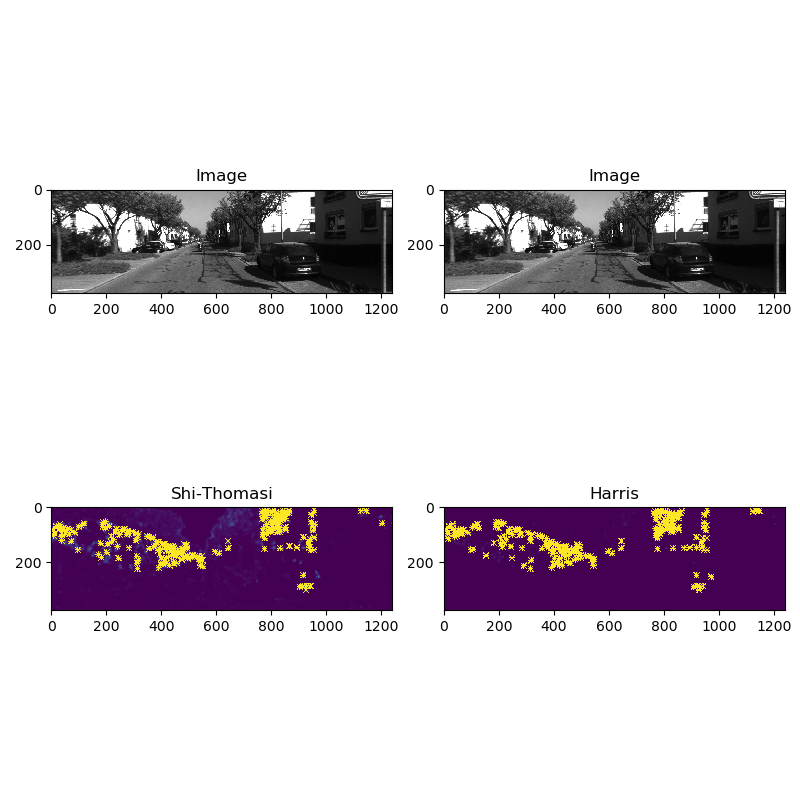

<IPython.core.display.Javascript object>


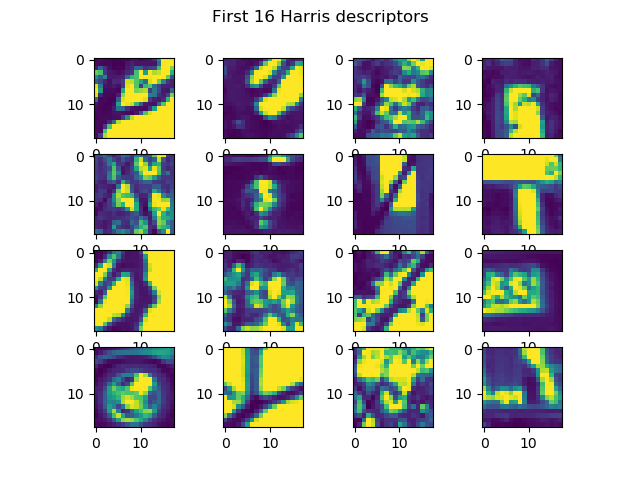

Text(0.5, 0.98, 'First 16 Harris descriptors')

In [197]:
%matplotlib notebook
ds = Dataset()
I = ds(0)

# harris
R_harris = harris_score(I, corner_patch_size, harris_kappa)
k_harris = select_keypoints(R_harris, num_keypoints, nonmaximum_supression_radius)
R_harris_ann = draw_keypoints(R_harris, kpts_harris)
d_harris = get_descriptors_from_keypoints(I, kpts_harris, descriptor_radius) 

# shi-thomasi
R_shi_thomasi = shi_thomasi_score(I, corner_patch_size)
k_shi_thomasi = select_keypoints(R_shi_thomasi, num_keypoints, nonmaximum_supression_radius)
R_shi_thomasi_ann = draw_keypoints(R_shi_thomasi, kpts_shi_thomasi)

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
ax[0][0].imshow(I.astype(int), cmap='gray')
ax[0][0].set_title("Image")

ax[0][1].imshow(I.astype(int), cmap='gray')
ax[0][1].set_title("Image")

ax[1][0].imshow(R_shi_thomasi_ann.astype(int))
ax[1][0].set_title("Shi-Thomasi")

ax[1][1].imshow(R_harris_ann.astype(int))
ax[1][1].set_title("Harris")
fig.tight_layout()

# Show the first harris descriptors
fig, ax = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(d_harris[:, i*4 + j].reshape(2*descriptor_radius, 2*descriptor_radius))
fig.suptitle("First 16 Harris descriptors")

### Two frames test

<IPython.core.display.Javascript object>


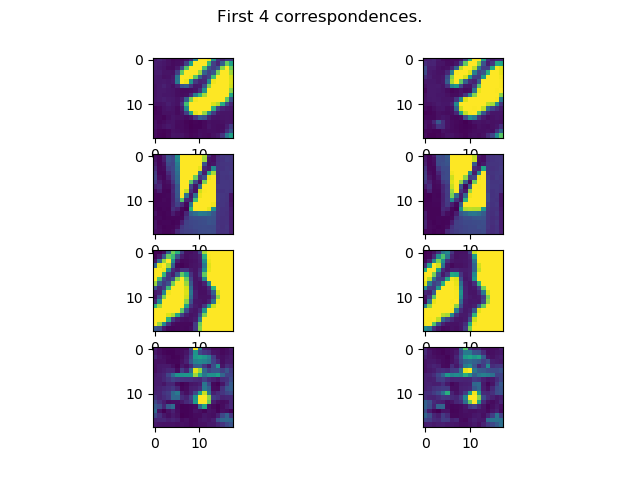

<IPython.core.display.Javascript object>


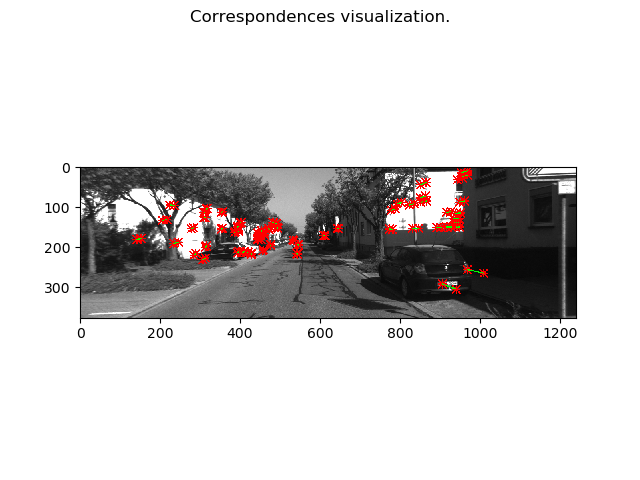

In [198]:
%matplotlib notebook
ds = Dataset()
img1 = ds(0)
img2 = ds(1)

kpts1, desc1 = get_harris_descriptors(img1)
kpts2, desc2 = get_harris_descriptors(img2)
matches = match_descriptors(desc2, desc1, 20)

# plot first 4 correspondences
fig, ax = plt.subplots(4, 2)
fig.suptitle("First 4 correspondences.")

match_idx = 0
for i in range(4):
    while matches[match_idx] == -1:
        match_idx += 1
    
    ax[i][0].imshow(desc2[:, match_idx].reshape(2*descriptor_radius, 2*descriptor_radius))
    ax[i][1].imshow(desc1[:, matches[match_idx]].reshape(2*descriptor_radius, 2*descriptor_radius))
    match_idx += 1
    
img_ann = draw_matches(img1, kpts2, kpts1, matches)
fig, ax = plt.subplots()
fig.suptitle("Correspondences visualization.")
ax.imshow(img_ann)

In [201]:
from matplotlib.animation import FuncAnimation
from IPython import display

# turn-off matplotlib in notebook plot
plt.ioff()
fig, ax = plt.subplots()

def animate(frame_num, ds, ax):
    img1 = ds(frame_num)
    img2 = ds(frame_num+1)
    
    kpts1, desc1 = get_harris_descriptors(img1)
    kpts2, desc2 = get_harris_descriptors(img2)
    matches = match_descriptors(desc2, desc1, 20)
    img_ann = draw_matches(img1, kpts2, kpts1, matches)
    ax.imshow(img_ann)
    
ds = Dataset()
anim = FuncAnimation(fig, animate, frames=40, interval=1000, fargs=(ds, ax))

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()